# Find the most repeated game titles in different areas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
%matplotlib inline
warnings.filterwarnings("ignore")

# create a dataFrame object with title, score and release_year
data = pd.read_csv("ign.csv")[["title", "genre", "platform", "score_phrase", "score", "release_year"]]

games_by_year = data.sort('release_year')
games_by_year.head()

,title,genre,platform,score_phrase,score,release_year
516,The Walking Dead: The Game -- Episode 1: A New...,Adventure,Xbox 360,Great,8.5,1970
519,Gex,Platformer,PlayStation,Okay,6.0,1996
460,NBA In the Zone,Sports,PlayStation,Mediocre,5.0,1996
461,Magic Carpet,Action,PlayStation,Good,7.5,1996
462,Power Serve 3D Tennis,Sports,PlayStation,Painful,2.0,1996


Couple of functions to make querying easier in general. No data here :(

In [2]:
# Counts the words in arr and returns a DataFrame which has a number of elements specified in see_how_many parameter
# TODO: fix with_score
def item_counter(arr, see_how_many, with_score):
    item_dict = {}
    for item in arr:
        if item in item_dict:
            item_dict[item] += 1
        else:
            item_dict[item] = 1

    most_used = sorted(item_dict, key = item_dict.get, reverse=True)[:see_how_many]
    
    res = []
    for item in most_used:
        res.append((item, item_dict[item]))

    df = pd.DataFrame.from_records(res, columns=("name", "frequency"))
    df.sort("frequency")
    return df

In [3]:
import nltk
import re
from nltk.corpus import stopwords

# Gets rid of meaningless words, numbers, non-letter characters in order to obtain better results
## not_wanted (list) - A list of words to avoid
## game_names (pandas.DataFrame) - Game titles to iterate
def preprocess(not_wanted, game_names):
    words = []
    for name in game_names:
        words_in_name = nltk.word_tokenize(name)    # Split the game names by words and extend the words array
        for i in range(0, len(words_in_name)):
            re_form = re.sub(r'[^a-zA-Z ]', '', words_in_name[i]).split()    # The regular expression for words only, get rid of all non-letter characters
            if (len(re_form) > 0 and  not (re_form[0].lower() in not_wanted) ):
                words_in_name[i] = re_form[0].lower()    # As splitting names, lower the characters to help them be found in stopwords
                words.append(words_in_name[i])
                
    sw = stopwords.words("english")
    # Get rid of stopwords and numbers in words array to analyze better.
    for i in sw:
        while i in words:
            words.remove(i)
                
    return words

In [4]:
# Generates a bar graph from a given result DataFrame
# TODO: find a way to widen the bar graph
def make_bar_graph(result, x_axis, y_axis):
    bar = result[[y_axis]].plot.barh(x=result[x_axis], legend=False, align="center", width=1.0, figsize=(10, 7), fontsize=12, color=np.random.rand(3,1))

A little bit more coding and finally, a list of most repeated words in game titles in the whole dataset.

In [5]:
# Unsignificant words, roman numerals and abbreviations to throw up, otherwise they can be seen in most common words many times.
DISTRACTIONS = ["i", "ii", "iii", "iv", "v", "vi", "vii", "fifa", "nba", "nfl", "vs", "k", "one", "two", "three", "four", "pga", "nhl", "ncaa"]

# Shows the word frequency of game titles with a bar graph
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
# TODO: words preprocessing can be inside of the item_counter
def see_every_game_name(make_graph, how_many):
    spec = data["title"]
    print "Checking", len(spec), "games."

    words = preprocess(DISTRACTIONS, spec)
    result = item_counter(words, how_many, False)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

In [6]:
# see_every_game_name(True, 20)

In [7]:
# Shows the word frequency of game titles with a bar graph using a score limit
## min_score (number) - Game names with scores >= min_score will be considered
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_score_limit(min_score, make_graph, how_many):
    spec = data.loc[data["score"] >= min_score]["title"]
    
    print "Checking", len(spec), "games."

    words = preprocess(DISTRACTIONS, spec)
    result = item_counter(words, how_many, False)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

In [8]:
see_game_names_with_score_limit(8.0, False, 10)

Checking 6632 games.


,name,frequency
0,edition,240
1,dead,117
2,world,116
3,game,113
4,episode,109
5,super,108
6,wars,103
7,star,101
8,soccer,96
9,pro,89


In [9]:
# Shows the word frequency of game titles with a bar graph using a classificiation (release_year, score_phrase etc) and a key (1996, "Amazing" etc.)
## column_value_tuples [tuple] - A list of tuples as (column_name, value_name) for querying the data
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_key(column_value_tuples, make_graph, how_many):
    spec = data
    for i in column_value_tuples:
        column = i[0]
        value = i[1]
        spec = spec.loc[spec[column] == value]
        
    print "Checking", len(spec), "games."
    
    words = preprocess(DISTRACTIONS, spec["title"])

    result = item_counter(words, how_many, False)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

Checking 1269 games.


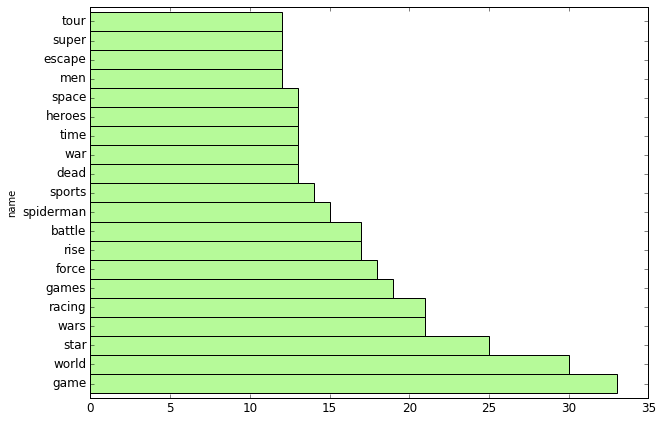

In [10]:
see_game_names_with_key([("score_phrase", "Bad")], True, 20)

Checking 1045 games.


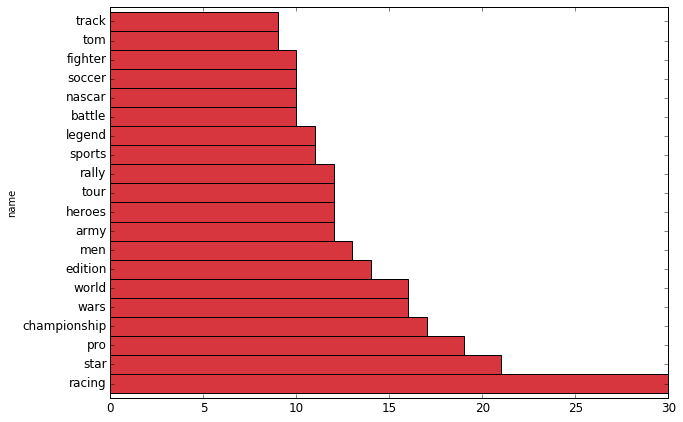

In [11]:
see_game_names_with_key([("release_year", 2000)], True, 20)

Let's see some **Amazing** games in **Sports**.

Checking 196 games.


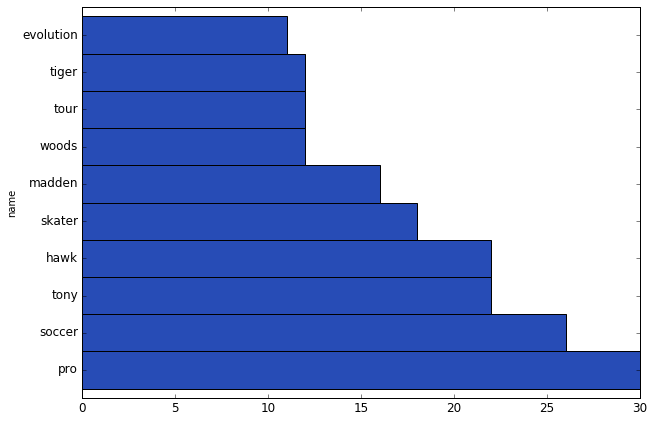

In [12]:
see_game_names_with_key([("genre", "Sports"), ("score_phrase", "Amazing")], True, 10)

In order to make things more interesting let's use a function to determine occurences of a word in different categories.

In [13]:
def word_occurences(given_words, column_value_tuples):
    spec = data
    for i in column_value_tuples:
        column = i[0]
        value = i[1]
        spec = spec.loc[spec[column] == value]
        
    print "Checking", len(spec), "games."
    
    words = preprocess(DISTRACTIONS, spec["title"])
    occurences = {}
    for word in given_words:
        occurence = words.count(word)
        occurences[word] = occurence
    
    return occurences

Are there any masterpieces with word "theft" except GTA games?

In [14]:
word_occurences(["grand", "theft", "auto"], [("score_phrase", "Masterpiece")])

Checking 55 games.


{'auto': 9, 'grand': 9, 'theft': 9}

Apparently not. Or better, we can see which score phrase has most of this word with the following function.

In [15]:
def where_can_i_find_the_most(words, desired_column):
    dict_for_most = {}
    properties = data[desired_column].unique()
    
    for column_type in properties:
        dict_for_most[column_type] = word_occurences(words, [(desired_column, column_type)])
    return dict_for_most

In [16]:
asd = where_can_i_find_the_most(["racing"], "genre")
asd

Checking 823 games.
Checking 776 games.
Checking 1916 games.
Checking 1071 games.
Checking 547 games.
Checking 980 games.
Checking 0 games.
Checking 765 games.
Checking 1175 games.
Checking 3797 games.
Checking 330 games.
Checking 1610 games.
Checking 371 games.
Checking 116 games.
Checking 1228 games.
Checking 77 games.
Checking 210 games.
Checking 22 games.
Checking 567 games.
Checking 32 games.
Checking 125 games.
Checking 200 games.
Checking 89 games.
Checking 25 games.
Checking 134 games.
Checking 77 games.
Checking 39 games.
Checking 44 games.
Checking 39 games.
Checking 196 games.
Checking 141 games.
Checking 32 games.
Checking 47 games.
Checking 6 games.
Checking 54 games.
Checking 1 games.
Checking 54 games.
Checking 24 games.
Checking 77 games.
Checking 112 games.
Checking 31 games.
Checking 5 games.
Checking 13 games.
Checking 37 games.
Checking 119 games.
Checking 3 games.
Checking 20 games.
Checking 82 games.
Checking 6 games.
Checking 1 games.
Checking 25 games.
Checking 

{nan: {'racing': 0},
 'Action': {'racing': 2},
 'Action, Adventure': {'racing': 0},
 'Action, Compilation': {'racing': 0},
 'Action, Editor': {'racing': 0},
 'Action, Platformer': {'racing': 0},
 'Action, Puzzle': {'racing': 0},
 'Action, RPG': {'racing': 0},
 'Action, Simulation': {'racing': 0},
 'Action, Strategy': {'racing': 0},
 'Adult, Card': {'racing': 0},
 'Adventure': {'racing': 0},
 'Adventure, Adult': {'racing': 0},
 'Adventure, Adventure': {'racing': 0},
 'Adventure, Compilation': {'racing': 0},
 'Adventure, Episodic': {'racing': 0},
 'Adventure, Platformer': {'racing': 0},
 'Adventure, RPG': {'racing': 0},
 'Baseball': {'racing': 0},
 'Battle': {'racing': 0},
 'Board': {'racing': 0},
 'Board, Compilation': {'racing': 0},
 'Card': {'racing': 0},
 'Card, Battle': {'racing': 0},
 'Card, Compilation': {'racing': 0},
 'Card, RPG': {'racing': 0},
 'Casino': {'racing': 0},
 'Compilation': {'racing': 0},
 'Compilation, Compilation': {'racing': 0},
 'Compilation, RPG': {'racing': 0}

The pie chart of the solutions.

In [17]:
from matplotlib.pyplot import pie, show
vs = []
ks = []
for v in asd.values():
    vs.append(float(v.values()[0]))
for k in asd.keys():
    ks.append(k)

print vs
print ks

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]
[nan, 'Sports, Baseball', 'Adventure, RPG', 'Hunting', 'Hunting, Action', 'Strategy, RPG', 'Educational, Trivia', 'Sports, Editor', 'Shooter, First-Person', 'Trivia', 'Shooter, Adventure', 'Platformer, Action', 'Shooter, RPG', 'Hunting, Simulation', 'Educational, Card', 'Action, RPG', 'Wrestling, Simulation', 'Simulation, Adventure', 'Simulation', 'Action, Strategy', 'Fighting, Action', 'RPG, Compilation', 'Pinball', 'Puzzle, A